## Portfolio Submission: DDoS Detection via Machine Learning Methodologies

The main goal of my project is to deliver a Denial-of-Service Attacks (DDoS) detection model based on a diverse set of traffic data collated by the Canadia Institute of Cybersecurity into the [CIC-DDoS2019 dataset](https://www.unb.ca/cic/datasets/ddos-2019.html). 

#### Table of Contents:

1. [Objective](#1)
2. [Dataset Information](#2)
3. [Preprocessing](#3)
   - [3.1 Training Data Breakdown](#3-1)
   - [3.2 Data Distribution: Train vs Test](#3-2)
   - [3.3 Creating Label Map and Droping Unreconciled Label Value ](#3-3)
   - [3.4 Duplicated and Missing Values Look-up](#3-4)
4. [Exploratory Data Analysis](#4)
   - [4.1 Identify Feature Types](#4-1)
   - [4.2 Categorical Features Visualization](#4-2)
   - [4.3 Traffic Distribution Flow Analysis](#4-3)
   - [4.4 Correlation Matrix](#4-4)
5. [Feature Engineering](#5)
   - [5.1 Selection](#5-1)
   - [5.2 Train/Test Split](#5-2)
   - [5.3 Encoding the Output Variable (Multiclass)](#5-3)
6. [Machine Learning Training](#6)
   - [6.1 Training](#6-1)
   - [6.2 Hyperparameter tuning and Best Model Selection](#6-2)
   - [6.3 F1 Score Plotting](#6-3)
   - [6.4 SHAP Plotting](#6-4)
7. [Conclusions and Final Recommendations](#7)

### 1. Objectives <a id="1"></a>

- Understanding the data available at hand
- Building a suite of classification models for our main target (output) variable
- Provide insights based on the best performing model

### 2. Dataset Information <a id="2"></a>

The **CIC-DDoS2019** dataset, released by the Canadian Institute for Cybersecurity, records two days of network activity that includes both benign traffic and twelve Distributed Denial-of-Service (DDoS) attack types. Background traffic stems from 25 profiled users (HTTP, HTTPS, FTP, SSH, email), while attacks are replayed in a controlled testbed and captured as PCAPs. Flow statistics—more than eighty per connection—are extracted with **CICFlowMeter-V3** and labelled by timestamp, endpoint, protocol, and attack class.

Attack techniques fall into two separate categories:

* **Reflection-based attacks**: adversaries spoof the victim’s IP when querying third-party “reflector” servers, causing those servers to flood the victim with oversized replies.  
* **Exploitation-based attacks**: adversaries target the victim directly, abusing protocol mechanics (e.g., half-open SYN handshakes or raw UDP floods) to exhaust resources.

#### Attack Taxonomy
| Attack family | Transport protocol(s) | Specific attack types captured in CIC-DDoS2019 |
|---------------|-----------------------|-----------------------------------------------|
| **Reflection-based** | TCP | MSSQL, SSDP |
| | UDP | CharGen, NTP, TFTP |
| | TCP&nbsp;or&nbsp;UDP | DNS, LDAP, NetBIOS, SNMP |
| **Exploitation-based** | TCP | SYN Flood |
| | UDP | UDP Flood, UDP-Lag |

Based on the attack taxonomy, our multiclass output (target) variable will be named `Label` and will take the following values:
|| <div style="text-align: left">Class values</div>|
|---------------|-----------------------------------------------|
|**`Label:`**|Syn, Benign, Portmap, UDP, UDPLag, MSSQL, NetBIOS and LDAP|

### 3. Preprocessing <a id="3"></a>

The project data is stored under `./data` and will be loaded programatically into the notebook. Additionally, there will be some data sanitizing taking place by removing null or duplicated values, dropping single value features, dropping highly correlated columns (`coef > 0.8`) in an effort to minimize multicolinearity.

There are also a feature names mismatch between training and testing data sets that will be corrected via mapping and renaming.

In [162]:
import os
import warnings
from tqdm import tqdm
from IPython.display import display, display_markdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Hide warnings for nicer formatting
warnings.filterwarnings('ignore')

In [7]:
def load_ddos_dataset(data_path='./data'):
    """
    Load CIC-DDoS2019 training and testing datasets, ensuring matching attack types.
    
    Args:
        data_path (str): Path to the directory containing the dataset files.
                         Defaults to './data'.
    
    Returns:
        tuple: (train_df, test_df) - Training and testing DataFrames with matching attack types
    """
    data_dir = Path(data_path)
    
    # Collect file paths using pathlib
    train_files = list(data_dir.glob('*-training.parquet'))
    test_files = list(data_dir.glob('*-testing.parquet'))
    
    # Extract attack type prefixes (e.g., 'DNS', 'LDAP', 'UDP')
    train_prefixes = {f.stem.split('-')[0] for f in train_files}
    test_prefixes = {f.stem.split('-')[0] for f in test_files}
    
    # Find common attack types between training and testing
    common_attacks = train_prefixes.intersection(test_prefixes)
    
    # Filter files to only include common attack types
    train_files_filtered = [f for f in train_files if f.stem.split('-')[0] in common_attacks]
    test_files_filtered = [f for f in test_files if f.stem.split('-')[0] in common_attacks]
    
    # Load datasets
    train_df = pd.concat([pd.read_parquet(f) for f in train_files_filtered], ignore_index=True)
    test_df = pd.concat([pd.read_parquet(f) for f in test_files_filtered], ignore_index=True)
    
    print(f"Loaded {len(common_attacks)} attack types: {sorted(common_attacks)}")
    print(f"Training shape: {train_df.shape}, Testing shape: {test_df.shape}")
    
    return train_df, test_df

train_df, test_df = load_ddos_dataset()

Loaded 6 attack types: ['LDAP', 'MSSQL', 'NetBIOS', 'Syn', 'UDP', 'UDPLag']
Training shape: (120065, 78), Testing shape: (38973, 78)


#### 3.1 Training Data Breakwdown <a id="3-1"></a>

In [11]:
train_df.head(5)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
1,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
3,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP
4,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP


In [9]:
train_df.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,120065.000000,...,120065.000000,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,120065.0,1.200650e+05,120065.0,120065.0
mean,9.847882,2.052619e+07,9.494665,5.229134,793.607300,2.857971e+03,193.468842,124.397636,139.754761,23.783621,...,5.671170,-1.248534e+07,7.801130e+04,7.839450e+04,1.821768e+05,3.275870e+04,6264210.5,1.559991e+06,7932698.5,4813855.0
std,5.306882,2.995552e+07,356.316717,46.543910,2773.260498,7.459666e+04,362.750641,250.786392,255.366257,89.622917,...,19.933391,1.145488e+08,4.512753e+05,3.853892e+05,8.238682e+05,3.747194e+05,10540597.0,3.189278e+06,12433032.0,9488153.0
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
25%,6.000000,4.110000e+02,2.000000,0.000000,36.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
50%,6.000000,1.096240e+05,4.000000,2.000000,72.000000,1.200000e+01,6.000000,6.000000,6.000000,0.000000,...,3.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
75%,17.000000,4.531427e+07,10.000000,4.000000,1076.000000,3.600000e+01,388.000000,52.000000,262.511108,7.905694,...,7.000000,2.000000e+01,3.766667e+01,3.323402e+01,1.010000e+02,1.000000e+00,12203672.0,2.413746e+06,15799887.0,7754443.0
max,17.000000,1.199975e+08,86666.000000,8029.000000,208524.000000,1.289243e+07,3625.000000,2131.000000,2131.000000,1448.583008,...,3888.000000,6.724045e+07,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,6.961402e+07,117569200.0,117569200.0


#### 3.2 Data Distribution: Train vs Test <a id="3-2"></a>

In [72]:
train_df["Label"].value_counts()

Label
Syn        48840
Benign     42007
UDP        18090
MSSQL       8523
LDAP        1906
NetBIOS      644
UDPLag        55
Name: count, dtype: int64

In [73]:
test_df["Label"].value_counts()

Label
Benign           10847
DrDoS_UDP        10420
UDP-lag           8872
DrDoS_MSSQL       6212
DrDoS_LDAP        1440
DrDoS_NetBIOS      598
Syn                533
WebDDoS             51
Name: count, dtype: int64

#### 3.3 Creating Label Map and Droping Unreconciled Label Value <a id="3-3"></a>

Based on the comparison above, we're noticing that the labels between _training_ and _testing_ datasets aren't fully reconciled. Furthermore, the `WebDDoS` label is only present in our test data, therefore it will need to be removed from training.

In [75]:
test_df = test_df[test_df["Label"] != "WebDDoS"];
test_df["Label"] = test_df["Label"].map({
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',
    'Benign': 'Benign'
})

# Output the test distribution again
test_df["Label"].value_counts()

Label
Benign     10847
UDP        10420
UDPLag      8872
MSSQL       6212
LDAP        1440
NetBIOS      598
Syn          533
Name: count, dtype: int64

#### 3.4 Duplicated and Missing Values Look-up <a id="3-4"></a>

In [80]:
# Check for missing and duplicated data records
display_markdown(f'''
|Missing Values|Duplicated Rows|
|--------------|---------------|
|{train_df.isnull().sum().sum()}|{train_df.duplicated().sum()}|
''', raw=True)


|Missing Values|Duplicated Rows|
|--------------|---------------|
|0|3195|


In [81]:
train_df = train_df.drop_duplicates() #Remove duplicates

### 4. Exploratory Data Analysis <a id="4"></a>

#### 4.1 Identify Feature Types <a id="4-1"></a>

In [91]:
def classify_features(data, cat_threshold=10, high_cardinality_threshold=20):
    """
    Classify DataFrame columns into categorical, numerical, and high-cardinality features.
    
    Args:
        data (pd.DataFrame): Input DataFrame
        cat_threshold (int): Maximum unique values for numerical features to be considered categorical
        high_cardinality_threshold (int): Minimum unique values for categorical features to be considered high-cardinality
    
    Returns:
        tuple: (categorical_features, high_cardinality_features, numerical_features)
    """
    # Get object (string) columns
    categorical_features = [col for col in data.columns if data[col].dtypes == "O"]
    
    # Get numerical columns with low cardinality (should be treated as categorical)
    low_cardinality_numerical = [
        col for col in data.columns 
        if data[col].nunique() < cat_threshold and data[col].dtypes != "O"
    ]
    
    # Get high cardinality categorical features
    high_cardinality_categorical = [
        col for col in data.columns 
        if data[col].nunique() > high_cardinality_threshold and data[col].dtypes == "O"
    ]
    
    # Combine categorical features and remove high cardinality ones
    categorical_features = categorical_features + low_cardinality_numerical
    categorical_features = [
        col for col in categorical_features 
        if col not in high_cardinality_categorical
    ]
    
    # Get numerical features (exclude low cardinality ones)
    numerical_features = [
        col for col in data.columns 
        if data[col].dtypes != "O" and col not in low_cardinality_numerical
    ]
    
    return categorical_features, high_cardinality_categorical, numerical_features

categorical_feats, high_cardinality_categorical, numerical_feats = classify_features(train_df)

# Output our feature analysis
display_markdown(f'''
|{len(categorical_feats)} Categorical Features|{len(high_cardinality_categorical)} High Cardinality Categorical Features| {len(numerical_feats)} Numerical Features|
|--------------------|-------------------------------------|------------------|
|{categorical_feats}|{high_cardinality_categorical}|{numerical_feats}|
''', raw=True)


|20 Categorical Features|0 High Cardinality Categorical Features| 58 Numerical Features|
|--------------------|-------------------------------------|------------------|
|['Label', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']|[]|['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Down/Up Ratio', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']|


#### 4.2 Categorical Features Visualization <a id="4-2-"></a>

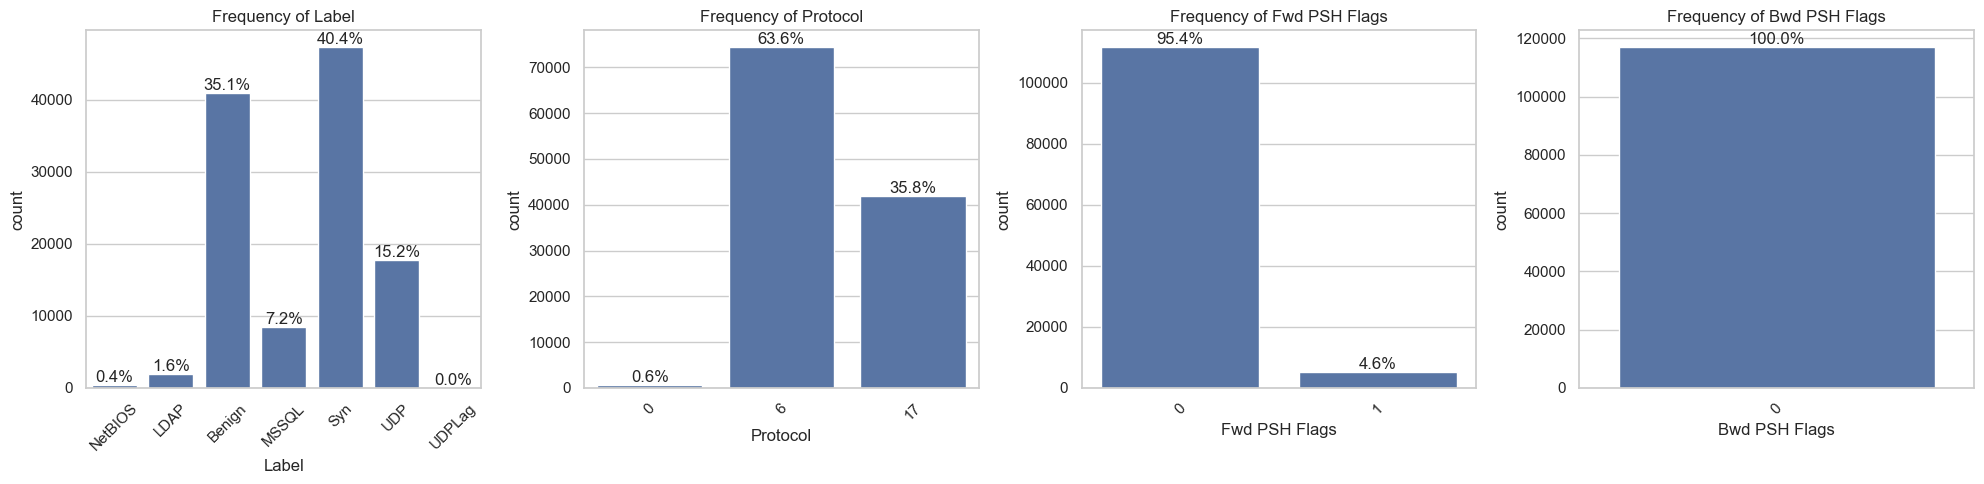

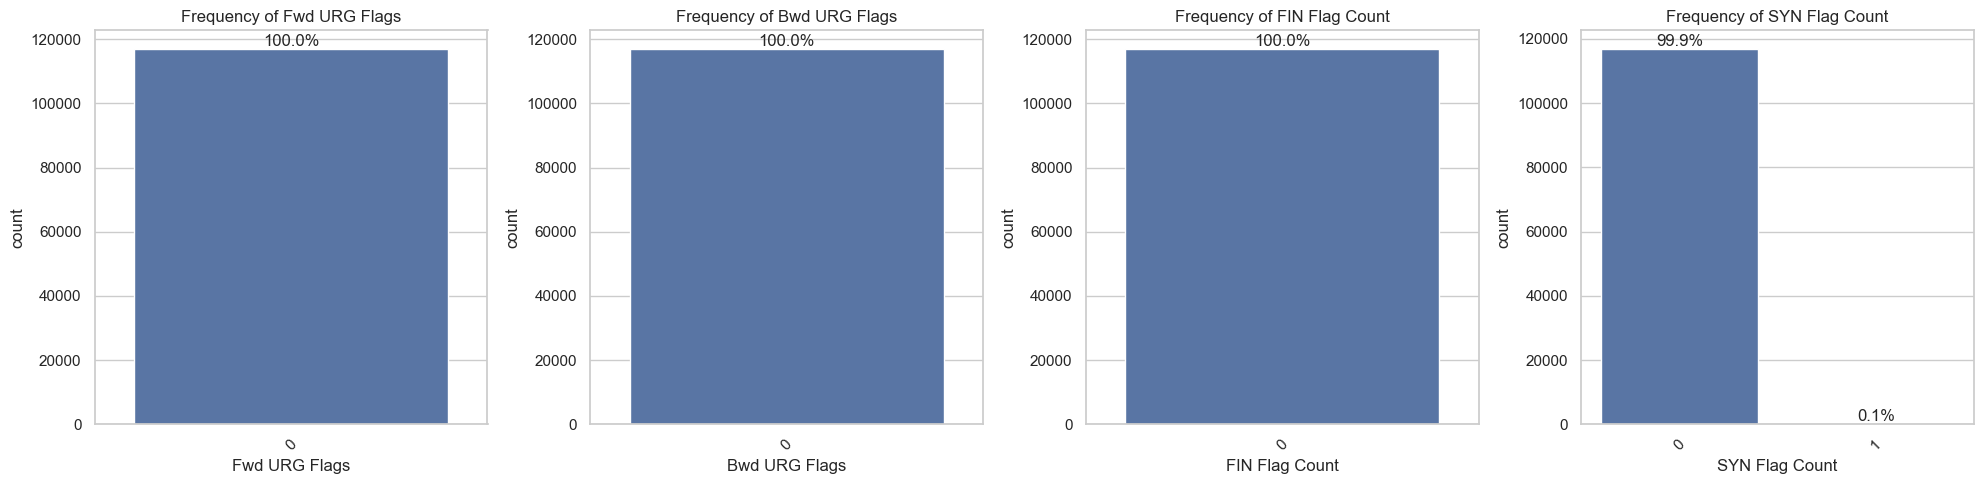

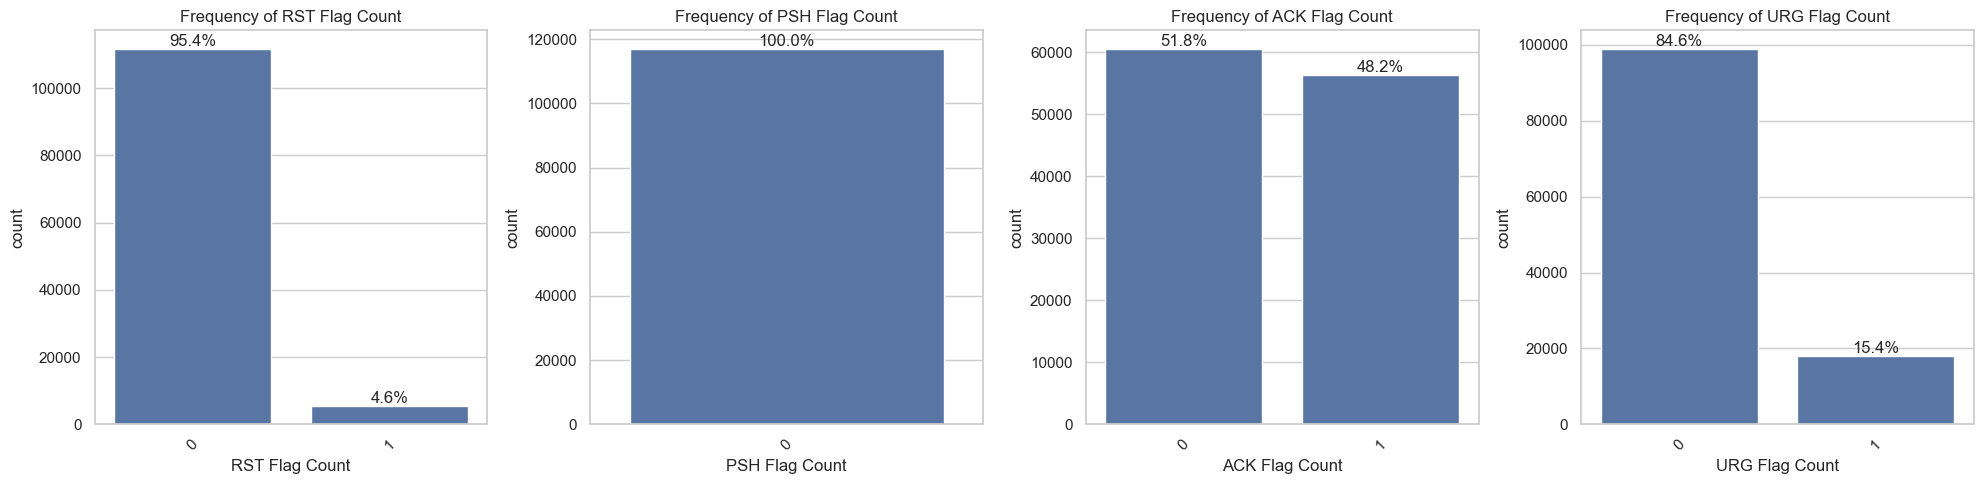

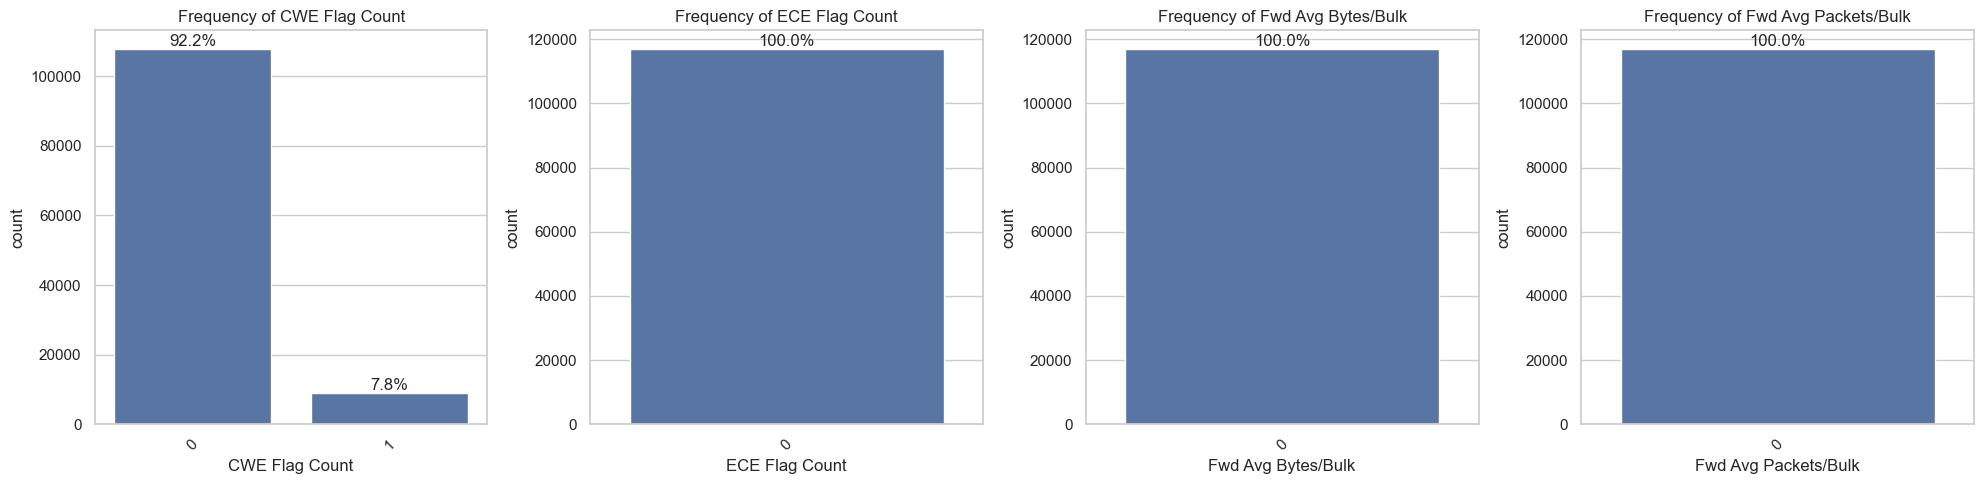

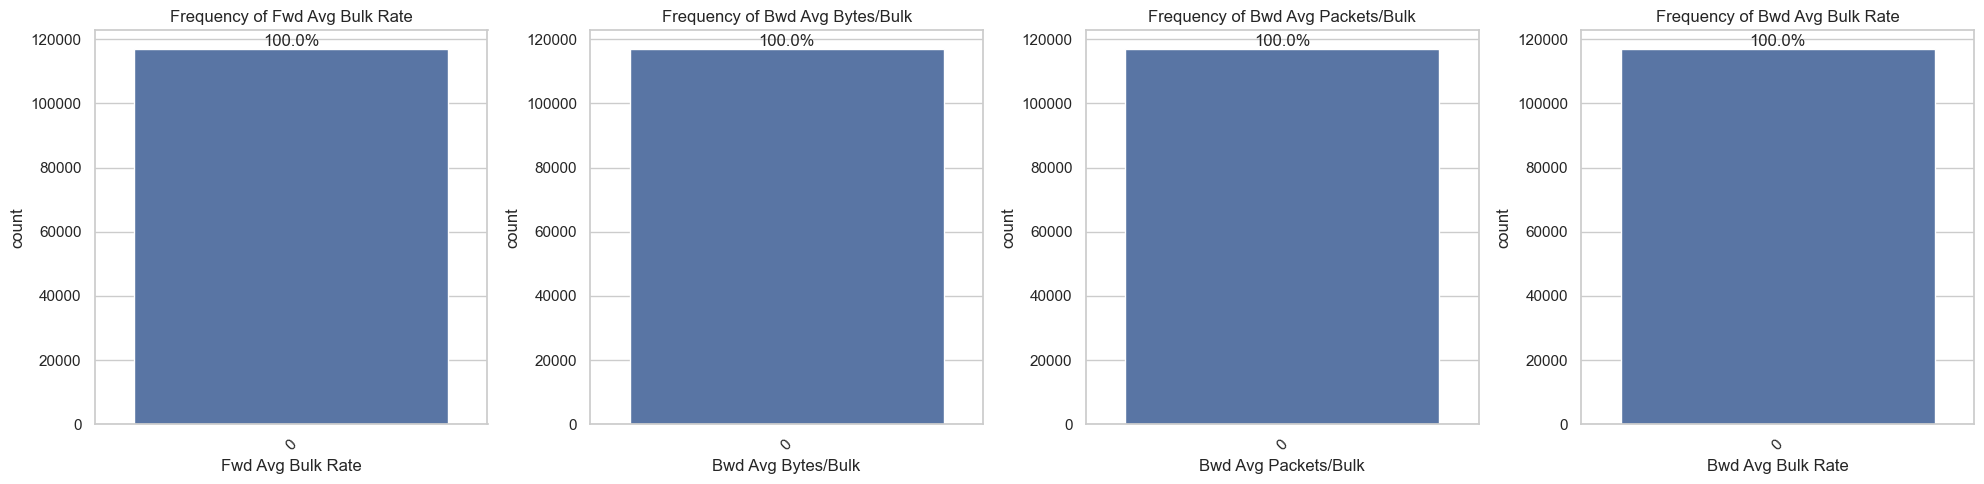

In [106]:
def plot_categorical_features_grid(data, categorical_features, plots_per_row=4):
    """
    Plot categorical features frequency with percentages in a grid layout.
    
    Args:
        data (pd.DataFrame): Input DataFrame
        categorical_features (list): List of categorical feature names
        plots_per_row (int): Number of plots per row (default: 4)
    """
    n_features = len(categorical_features)
    n_rows = (n_features + plots_per_row - 1) // plots_per_row  # Ceiling division
    
    for i in range(0, n_features, plots_per_row):
        batch_features = categorical_features[i:i + plots_per_row]
        fig, axes = plt.subplots(1, len(batch_features), figsize=(20, 5))
        
        # Handle single plot case
        if len(batch_features) == 1:
            axes = [axes]
        
        for j, feature in enumerate(batch_features):
            # Create count plot
            ax = sns.countplot(x=feature, data=data, ax=axes[j])
            axes[j].tick_params(axis='x', rotation=45)
            axes[j].set_title(f"Frequency of {feature}")
            
            # Add percentage labels on bars
            total = len(data[feature].dropna())
            for p in ax.patches:
                percentage = f'{100 * p.get_height() / total:.1f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

# Usage
plot_categorical_features_grid(train_df, categorical_feats, plots_per_row=4)

#### 4.3 Traffic Distribution Flow Analysis <a id="4-3"></a>

<Figure size 640x480 with 0 Axes>

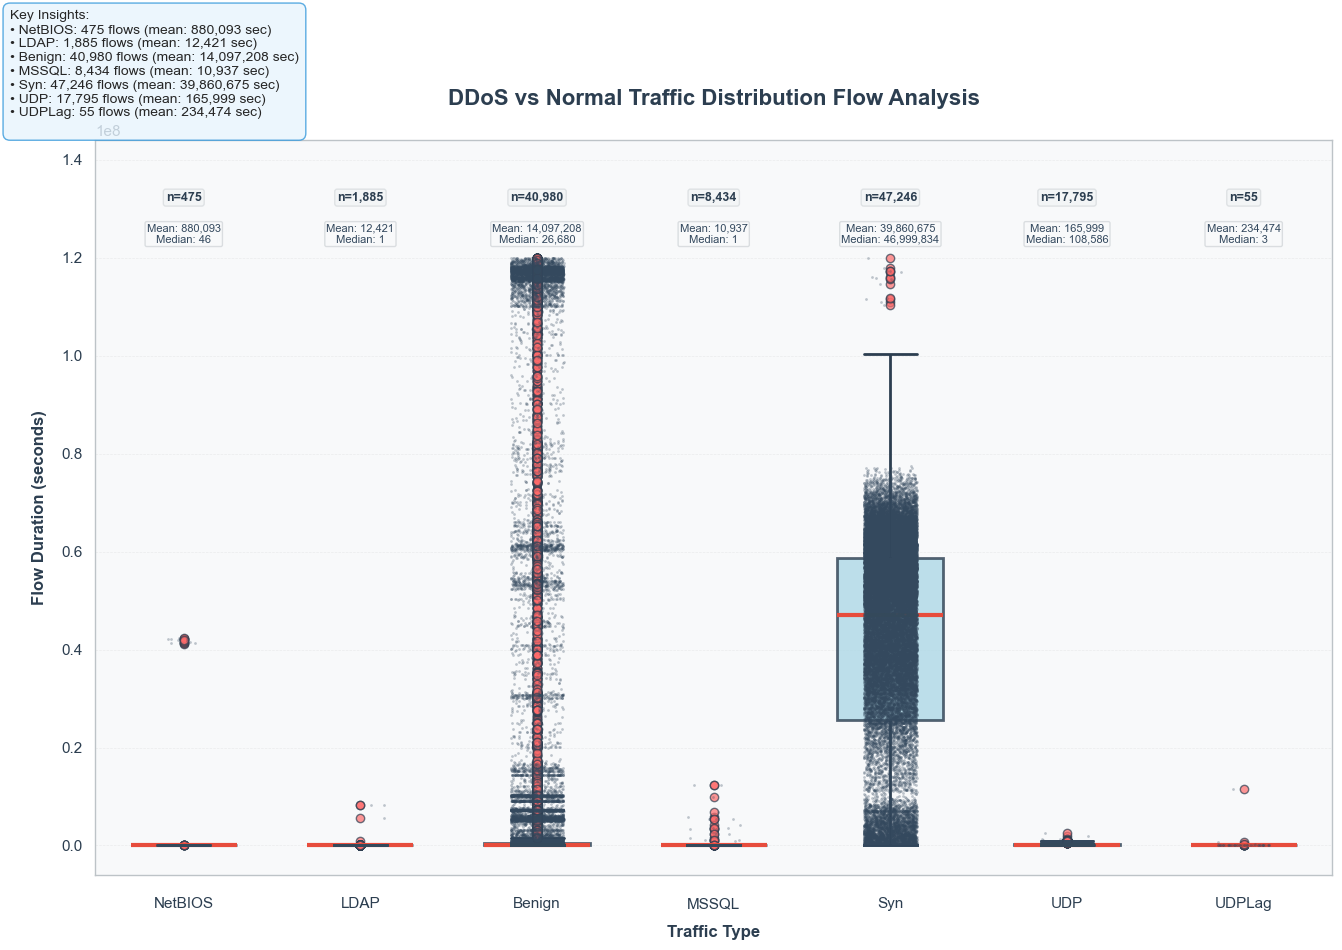

In [107]:
# Clear any existing plots and set style
plt.clf()
plt.style.use('default')  # Use default style to avoid conflicts
sns.set_theme(style="whitegrid")  # Use seaborn's clean whitegrid style

# Create figure with better proportions and extra space for insights
fig, ax = plt.subplots(figsize=(14, 10), dpi=100, facecolor='white')

# Create enhanced boxplot
box_plot = sns.boxplot(
    x="Label", y="Flow Duration", data=train_df,
    palette=['#2E8B57', '#DC143C'],  # Green for Normal, Red for DDoS
    width=0.6, linewidth=2,
    flierprops=dict(marker='o', markerfacecolor='#FF6B6B', markersize=6, 
                   markeredgecolor='#2C3E50', markeredgewidth=1, alpha=0.7),
    boxprops=dict(facecolor='lightblue', alpha=0.8, edgecolor='#2C3E50', linewidth=2),
    medianprops=dict(color='#E74C3C', linewidth=3),
    whiskerprops=dict(color='#2C3E50', linewidth=2),
    capprops=dict(color='#2C3E50', linewidth=2),
    ax=ax
)

# Add individual data points with reduced opacity to avoid overwhelming the boxplot
sns.stripplot(x="Label", y="Flow Duration", data=train_df, color='#34495E', 
              size=2, alpha=0.3, jitter=0.15, ax=ax)

# Calculate and add statistics
stats = train_df.groupby('Label')['Flow Duration'].agg(['count', 'mean', 'median']).round(2)
labels = train_df['Label'].unique()

# Get the maximum y value for better annotation positioning
y_max = train_df['Flow Duration'].max()
y_range = train_df['Flow Duration'].max() - train_df['Flow Duration'].min()

for i, label in enumerate(labels):
    count = stats.loc[label, 'count']
    mean_val = stats.loc[label, 'mean']
    median_val = stats.loc[label, 'median']
    
    # Better positioning to avoid overlapping
    y_pos_count = y_max + y_range * 0.08
    y_pos_stats = y_max + y_range * 0.04
    
    # Add count annotation (top)
    ax.annotate(f'n={count:,}', 
                xy=(i, y_pos_count), 
                xytext=(0, 5), 
                textcoords='offset points',
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='#2C3E50',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='#ECF0F1', alpha=0.4, edgecolor='#BDC3C7'))
    
    # Add mean/median annotation (below count)
    ax.annotate(f'Mean: {mean_val:,.0f}\nMedian: {median_val:,.0f}', 
                xy=(i, y_pos_stats), 
                xytext=(0, 0), 
                textcoords='offset points',
                ha='center', va='center', 
                fontsize=8, color='#34495E',
                bbox=dict(boxstyle='round,pad=0.15', facecolor='#F8F9FA', alpha=0.5, edgecolor='#BDC3C7'))

# Customize appearance
ax.set_title('DDoS vs Normal Traffic Distribution Flow Analysis', 
             fontsize=16, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Traffic Type', fontsize=12, fontweight='bold', color='#2C3E50', labelpad=10)
ax.set_ylabel('Flow Duration (seconds)', fontsize=12, fontweight='bold', color='#2C3E50', labelpad=10)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50')
ax.tick_params(axis='x', which='major', pad=10)

# Set background and grid
ax.set_facecolor('#F8F9FA')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')

# Extend y-axis to accommodate annotations
y_current_max = ax.get_ylim()[1]
ax.set_ylim(bottom=ax.get_ylim()[0], top=y_current_max + y_range * 0.15)

# Add insights box - dynamically handle any label values
if len(labels) == 2:
    label1, label2 = labels[0], labels[1]
    count1 = stats.loc[label1, 'count']
    count2 = stats.loc[label2, 'count']
    mean1 = stats.loc[label1, 'mean']
    mean2 = stats.loc[label2, 'mean']
    
    insights_text = f"""Key Insights:
• {label1}: {count1:,} flows
• {label2}: {count2:,} flows  
• Duration diff: {abs(mean1 - mean2):,.0f} sec
• {label2} flows are {'longer' if mean2 > mean1 else 'shorter'} than {label1} flows"""
else:
    # Handle case with more than 2 labels
    insights_text = "Key Insights:\n"
    for label in labels:
        count = stats.loc[label, 'count']
        mean_val = stats.loc[label, 'mean']
        insights_text += f"• {label}: {count:,} flows (mean: {mean_val:,.0f} sec)\n"

# Position insights box ABOVE the plot title (outside plot area)
fig.text(0.02, 0.98, insights_text, transform=fig.transFigure, fontsize=10, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#E8F4FD', alpha=0.8, edgecolor='#3498DB'))

# Add subtle border
for spine in ax.spines.values():
    spine.set_color('#BDC3C7')
    spine.set_linewidth(1)

# Adjust layout to prevent cutoff and accommodate insights box
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85)  # Make room for insights box above

plt.show() 

#### 4.4 Correlation Matrix <a id="4-4"></a>

<Figure size 640x480 with 0 Axes>

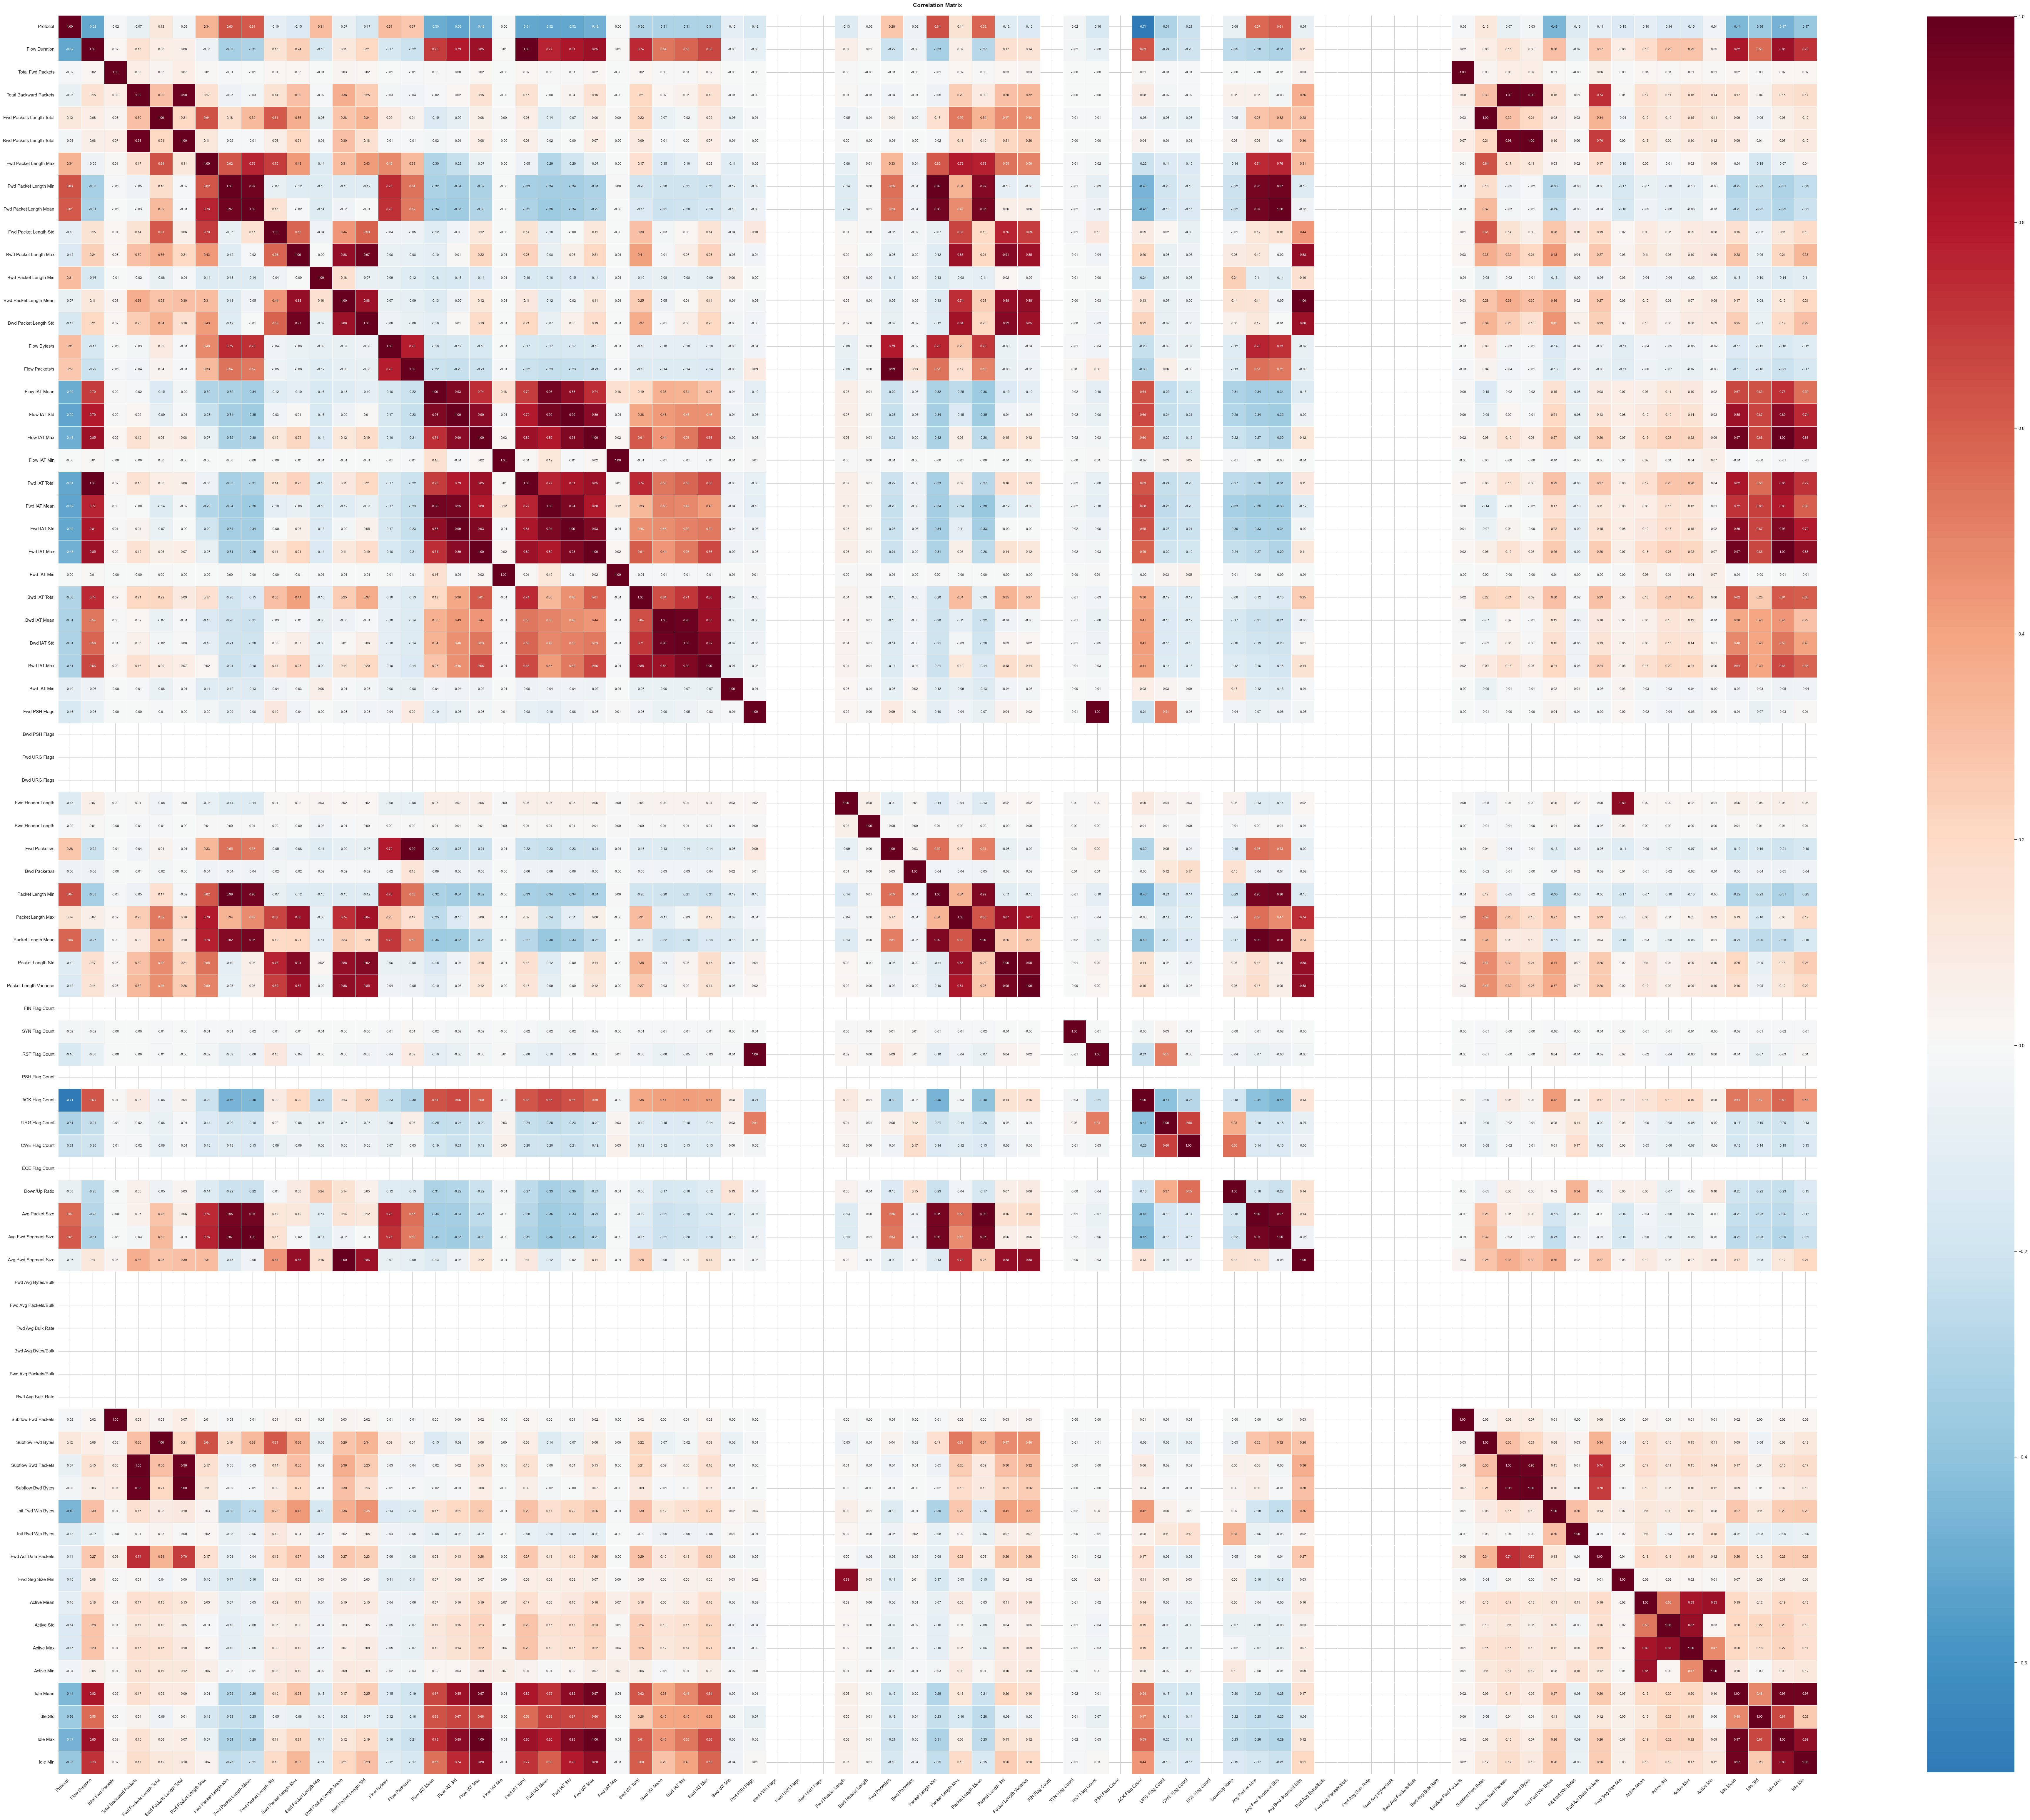

In [118]:
def simple_correlation_matrix(data, size=None, save_path=None):
    """
    Simple correlation matrix - just the image, no extra output.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataframe
    size : tuple, optional
        Figure size (width, height). If None, auto-calculated.
    save_path : str, optional
        Path to save the image (e.g., 'correlation_matrix.png')
    """
    
    # Clear any existing plots
    plt.clf()
    
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Auto-calculate size if not provided
    if size is None:
        n_cols = len(numeric_data.columns)
        size = (max(8, n_cols), max(6, n_cols-2))
    
    # Create the correlation matrix
    plt.figure(figsize=size)
    sns.heatmap(numeric_data.corr(), 
                annot=True, 
                fmt='.2f', 
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.8},
                annot_kws={'size': 8})
    
    plt.title("Correlation Matrix", fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

simple_correlation_matrix(data=train_df, save_path='correlation_matrix.png')

### 5. Feature Engineering <a id="5"></a>

#### 5.1 Selection <a id="5-1"></a>

In [139]:
# Search and remove single value features
single_val_feats = [feat for feat in train_df.columns if train_df[feat].nunique() == 1]

if len(single_val_feats) > 0:
    display_markdown(f'''
|{len(single_val_feats)} single value features found. Dropping|
|-----------------------------|
|{single_val_feats}|''',
    raw=True)
    train_df.drop(single_val_feats, axis=1, inplace = True)
    test_df.drop(single_val_feats, axis=1, inplace = True)

# Select numerical feats and recaculate the matrix
numerical_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr().abs()

# Select upper triangle of the matrix
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_triangle = corr_matrix.where(mask)

# Identify high correlation feats and remove them
high_corr_feats = [feat for feat in upper_triangle.columns if any(upper_triangle[feat] > 0.8)]

if len(high_corr_feats) > 0:
    display_markdown(f'''
|{len(high_corr_feats)} highly correlated features found. Dropping|
|-----------------------------|
|{high_corr_feats}|''',
    raw=True)
    train_df.drop(high_corr_feats, axis=1, inplace = True)
    test_df.drop(high_corr_feats, axis=1, inplace = True)



|12 single value features found. Dropping|
|-----------------------------|
|['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']|


|33 highly correlated features found. Dropping|
|-----------------------------|
|['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']|

In [141]:
print(f"Training data shape:{train_df.shape} | Test data shape {test_df.shape}")

Training data shape:(116870, 33) | Test data shape (38922, 33)


#### 5.2 Train/Test Split <a id="5-2"></a>

In [144]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]

display_markdown(f'''
|X info| y info|
|------|-------|
|{X_train.shape, X_val.shape, X_test.shape}|{y_train.shape, y_val.shape, y_test.shape}|
''', raw=True)


|X info| y info|
|------|-------|
|((93496, 32), (23374, 32), (38922, 32))|((93496,), (23374,), (38922,))|


#### 5.3 Encoding the Output Variable (Multiclass) <a id="5-3"></a>

In [148]:
# Encode the target variable
class LabelEncoderModel:
    def __init__(self):
        self.encoder = LabelEncoder()
        self.label_map = {}
    
    def fit_transform_all(self, y_train, y_val, y_test):
        """Fit on training data and transform all datasets."""
        # Fit and transform training data
        y_train_encoded = self.encoder.fit_transform(y_train)
        
        # Transform validation and test data
        y_val_encoded = self.encoder.transform(y_val)
        y_test_encoded = self.encoder.transform(y_test)
        
        # Create label mapping
        self.label_map = dict(enumerate(self.encoder.classes_))
        
        return y_train_encoded, y_val_encoded, y_test_encoded
    
    def get_label_mapping(self):
        """Get the label mapping dictionary."""
        return self.label_map

encoder = LabelEncoderModel()

# Now use the instance
y_train_encoded, y_val_encoded, y_test_encoded = encoder.fit_transform_all(y_train, y_val, y_test)
label_mapping = encoder.get_label_mapping()

# Display results
display_markdown(f'''
|Label Mapping|Training|Validation|Test|
|-------------|---------------------|-----------------------|-----------------|
|{label_mapping}|{y_train_encoded.shape}|{y_val_encoded.shape}|{y_test_encoded.shape}|
''', raw=True) 


|Label Mapping|Training|Validation|Test|
|-------------|---------------------|-----------------------|-----------------|
|{0: 'Benign', 1: 'LDAP', 2: 'MSSQL', 3: 'NetBIOS', 4: 'Syn', 5: 'UDP', 6: 'UDPLag'}|(93496,)|(23374,)|(38922,)|


### 6. Machine Learning Pipeline <a id="6"></a>

#### 6.1 Training <a id="6-1"><a/>

Start with comparison based on a predefined range of multiclassing models.

In [160]:
# Initialize models with preprocessing pipeline
classifiers = {
    "Random Forest": Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', RandomForestClassifier())
    ]),
    "KNN": Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=10))
    ]),
    "Extra Trees": Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', ExtraTreesClassifier())
    ]),
    "XGBoost": Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', XGBClassifier())
    ]),
    "MLP Classifier": Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100)))
    ])
}

# Train and evaluate models
results = {}
for name, pipeline in classifiers.items():
    print(f"Training {name}...")
    
    # Train pipeline (includes preprocessing + model)
    pipeline.fit(X_train, y_train_encoded) #using our encoded labels to prevent XGBoost errors in particular
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test_encoded, pipeline.predict_proba(X_test), multi_class="ovr")
    cv_score = np.mean(cross_val_score(pipeline, X_train, y_train_encoded, cv=5))
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'CV Score': cv_score
    }
    
    # Print results
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

# Create DataFrame and display
scores = pd.DataFrame(results).T
print("\nBest Scores between different models:")
display(scores.style.background_gradient(cmap='viridis'))

Training Random Forest...
Random Forest: Accuracy = 0.7453, F1 = 0.6555, ROC AUC = 0.8974
Training KNN...
KNN: Accuracy = 0.7460, F1 = 0.7119, ROC AUC = 0.8858
Training Extra Trees...
Extra Trees: Accuracy = 0.7396, F1 = 0.6460, ROC AUC = 0.8913
Training XGBoost...
XGBoost: Accuracy = 0.7515, F1 = 0.7135, ROC AUC = 0.9052
Training MLP Classifier...
MLP Classifier: Accuracy = 0.7480, F1 = 0.7110, ROC AUC = 0.8838

Best Scores between different models:


,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score
Random Forest,0.745260,0.822225,0.745260,0.655502,0.897411,0.993583
KNN,0.746031,0.920682,0.746031,0.711883,0.885821,0.990534
Extra Trees,0.739556,0.784110,0.739556,0.646016,0.891265,0.993048
XGBoost,0.751477,0.885548,0.751477,0.713451,0.905224,0.992128
MLP Classifier,0.747983,0.689452,0.747983,0.711016,0.883769,0.988502


#### 6.2 Hyperparameter tuning and Best Model Selection <a id="6-2"></a>

In [164]:
# Define parameter grids for each model
param_grids = {
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': [2, 5]
    },
    "KNN": {
        'classifier__n_neighbors': [5, 10],
        'classifier__weights': ['uniform', 'distance']
    },
    "Extra Trees": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, None]
    },
    "XGBoost": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1, 0.2]
    },
    "MLP Classifier": {
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__alpha': [0.001, 0.01]
    }
}

# Train and evaluate models with hyperparameter tuning
results = {}
best_models = {}

for name, pipeline in classifiers.items():
    print(f"\n{'='*50}")
    print(f"Training {name} with hyperparameter tuning...")
    print(f"{'='*50}")
    
    # Perform hyperparameter tuning
    if name in param_grids:
        # Use GridSearchCV for systematic search
        grid_search = GridSearchCV(
            pipeline, 
            param_grids[name], 
            cv=5, 
            scoring='f1_weighted',
            n_jobs=-1,  # Use all CPU cores
            verbose=1
        )
        
        # Fit the grid search
        grid_search.fit(X_train, y_train_encoded)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print(f"Best parameters: {best_params}")
        print(f"Best CV score: {best_score:.4f}")
        
        # Store best model
        best_models[name] = best_model
        
    else:
        # No hyperparameter tuning for this model
        best_model = pipeline.fit(X_train, y_train_encoded)
        best_models[name] = best_model
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test_encoded, best_model.predict_proba(X_test), multi_class="ovr")
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Best CV Score': best_score if name in param_grids else np.nan
    }
    
    # Print results
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

# Create DataFrame and display
scores = pd.DataFrame(results).T
print(f"\n{'='*60}")
print("FINAL RESULTS - Best Scores between different models:")
print(f"{'='*60}")
display(scores.style.background_gradient(cmap='viridis'))

# Find the best overall model
best_overall_model = max(results.items(), key=lambda x: x[1]['F1 Score'])
print(f"\nBest overall model: {best_overall_model[0]} (F1 Score: {best_overall_model[1]['F1 Score']:.4f})")


Training Random Forest with hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV score: 0.9935
Random Forest: Accuracy = 0.7408, F1 = 0.6463, ROC AUC = 0.9063

Training KNN with hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Best CV score: 0.9920
KNN: Accuracy = 0.7464, F1 = 0.7128, ROC AUC = 0.8824

Training Extra Trees with hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best CV score: 0.9930
Extra Trees: Accuracy = 0.7392, F1 = 0.6456, ROC AUC = 0.8928

Training XGBoost with hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier__le

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Best CV Score
Random Forest,0.740764,0.811822,0.740764,0.646268,0.906257,0.993520
KNN,0.746416,0.922558,0.746416,0.712824,0.882440,0.992015
Extra Trees,0.739222,0.783060,0.739222,0.645561,0.892826,0.992953
XGBoost,0.751914,0.919537,0.751914,0.714254,0.904217,0.992172
MLP Classifier,0.747392,0.688185,0.747392,0.710194,0.902742,0.988623



Best overall model: XGBoost (F1 Score: 0.7143)


#### 6.3 F1 Score Plotting <a id="6-3"></id>

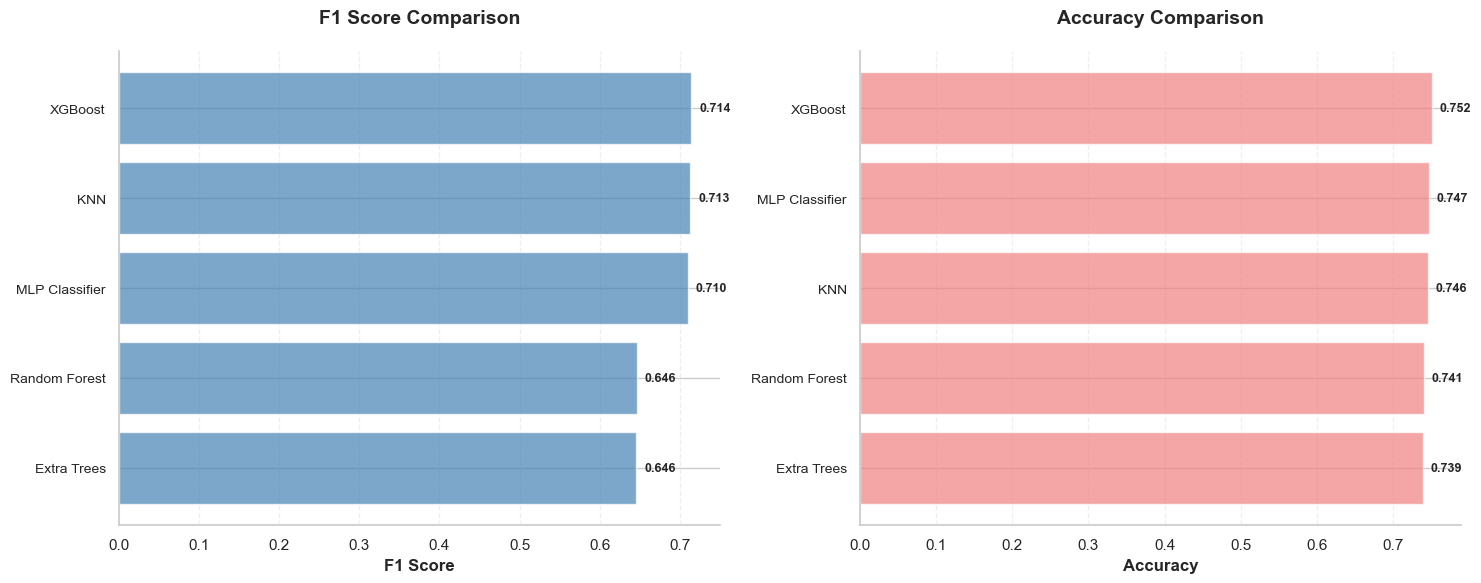


MODEL PERFORMANCE SUMMARY
Best F1 Score: 0.7143 (XGBoost)
Best Accuracy: 0.7519 (XGBoost)
Average F1 Score: 0.6858
Average Accuracy: 0.7451


In [173]:
def plot_model_comparison(results):
    """Simple plot comparing F1 scores and accuracy across models."""
    
    # Convert results to DataFrame
    scores = pd.DataFrame(results).T
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: F1 Scores
    f1_scores = scores['F1 Score'].sort_values(ascending=True)
    bars1 = ax1.barh(range(len(f1_scores)), f1_scores, color='steelblue', alpha=0.7)
    ax1.set_yticks(range(len(f1_scores)))
    ax1.set_yticklabels(f1_scores.index, fontsize=10)
    ax1.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
    ax1.set_title('F1 Score Comparison', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on F1 bars
    for i, (bar, value) in enumerate(zip(bars1, f1_scores)):
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Accuracy Scores
    accuracy_scores = scores['Accuracy'].sort_values(ascending=True)
    bars2 = ax2.barh(range(len(accuracy_scores)), accuracy_scores, color='lightcoral', alpha=0.7)
    ax2.set_yticks(range(len(accuracy_scores)))
    ax2.set_yticklabels(accuracy_scores.index, fontsize=10)
    ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on Accuracy bars
    for i, (bar, value) in enumerate(zip(bars2, accuracy_scores)):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Remove spines for cleaner look
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*50}")
    print("MODEL PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Best F1 Score: {scores['F1 Score'].max():.4f} ({scores['F1 Score'].idxmax()})")
    print(f"Best Accuracy: {scores['Accuracy'].max():.4f} ({scores['Accuracy'].idxmax()})")
    print(f"Average F1 Score: {scores['F1 Score'].mean():.4f}")
    print(f"Average Accuracy: {scores['Accuracy'].mean():.4f}")

# Usage: Call after your hyperparameter tuning loop
plot_model_comparison(results)

#### 6.4 SHAP Plotting <a id="6-4"></a>

<Figure size 1000x600 with 0 Axes>

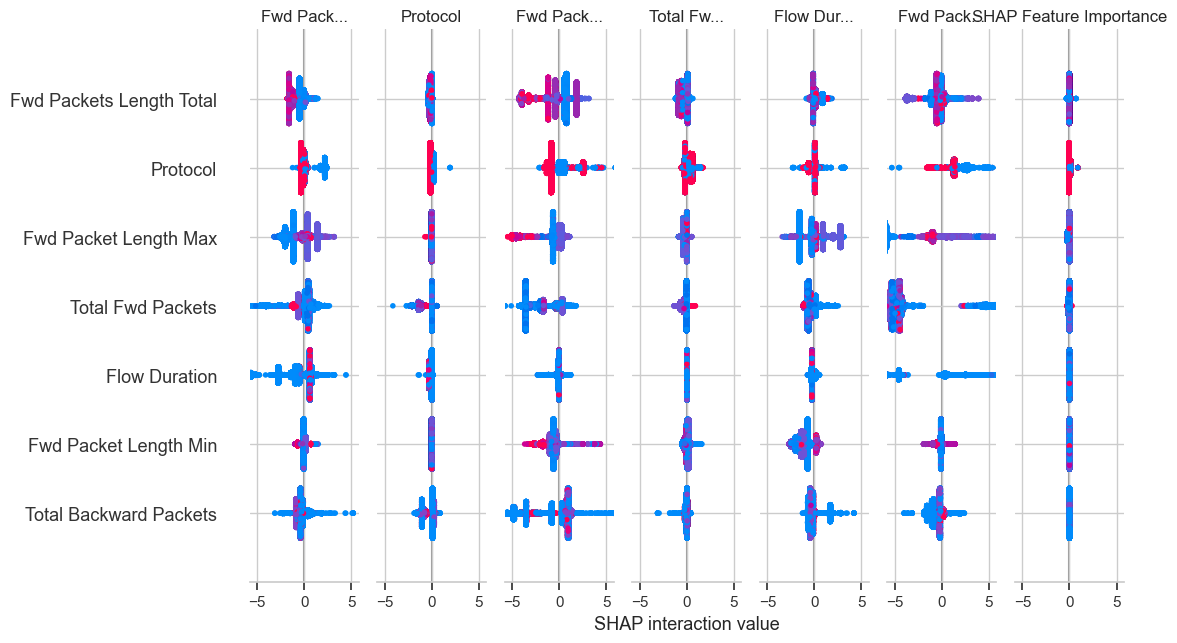


Top 5 Most Important Features:
                  Feature  Importance
22         ACK Flag Count    0.404158
23         URG Flag Count    0.274550
20          Bwd Packets/s    0.139729
6   Fwd Packet Length Min    0.059704
7   Fwd Packet Length Std    0.035812


In [172]:
import shap

# Simple SHAP explanation for the best model
def simple_shap_explanation(best_model, X_test, feature_names=None):
    """Simple SHAP explanation for the best model."""
    
    # Get feature names
    if feature_names is None:
        feature_names = X_test.columns.tolist()
    
    # Get preprocessed data
    X_test_scaled = best_model.named_steps['scaler'].transform(X_test)
    classifier = best_model.named_steps['classifier']
    
    # Create explainer
    if hasattr(classifier, 'feature_importances_'):
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_scaled)
    else:
        explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_test_scaled, 50))
        shap_values = explainer.shap_values(X_test_scaled)
    
    # Simple summary plot
    plt.figure(figsize=(10, 6))
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[0], X_test_scaled, feature_names=feature_names, show=False)
    else:
        shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Print top features
    if hasattr(classifier, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': classifier.feature_importances_
        }).sort_values('Importance', ascending=False)
        print(f"\nTop 5 Most Important Features:")
        print(importance_df.head())

# Run simple explanation
simple_shap_explanation(best_models[best_overall_model[0]], X_test)

### 7 Conclusion and Final Recommendations

Based on the final scores, the  most promising model is `XGBoost` due to its overall accuracy across a couple of key metrics
- `F1 Score of 0.7143`: Due to the imbalanced nature of the dataset, containing multiple metrics across different features for multiple classes, this is the best evaluation to go by, as it is representing the harmonic mean between precision and recall rates. As such, it provides the best overall accuracy for our models.
- `Accuracy of 0.7519`: Based on our recalculated confusion matrix (using upper triangle bound), XGBoost provides again the best rate between all four possible outcomes in the confusion matrix.
- `ROC AUC of 0.904217`: The Receiver Operating Characteristic Area Under the Curve is also particularly important, as it is actually displaying the ability of our model to understand whether the traffic is malign or benign. In terms of scoring, XGBoost places third, but combined with the overall metric performance, it still displays excellent detection capability.

Best model configuration is: `{'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}`

**Final recommendations:**
- Due to computing limitations the hyperparameter tuning values have been kept light. These could be increased on a cloud platform with better processing power scaling.
- The overall accuracy scores of `~71/75%` are not within the best range they could be. Ideally our detection rate should be well above `90%`. Further data optimization research could help bump up these numbers.

